In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [39]:
xls = pd.ExcelFile('20180509_Business_Analyst_Case.xlsx')
df = pd.read_excel(xls, 'Data')

In [40]:
df = df.drop(np.arange(7)).reset_index()
df.columns = df.iloc[0]
df = df[1:]
df = df.reset_index().drop(columns = [7, 'index'])
df.columns = df.columns.str.lower().str.replace(' ', '_')

### Customer Orders Data
- **"Customer":** Unique customers who started buying our products in Jan or February 2018
- **"Date Shipped":** Date when orders were fulfilled.  Note that some customers made multiple orders (repeat purchases) while other customers did not.
- **"Product ID":** Unique SKU representing which product was ordered
- **"Brand":**  The customers were buyers of one of 3 brands.  They only purchased from 1 of the 3.
- **"Channel":** How we acquired these customers

# Insight Questions - What keeps customers coming back?
<ol>
    <li> Which brand(s) are stronger and which are weaker at driving repeat purchases? </li>
    <li>Does the marketing channel used to acquire customers make a difference?  </li>
    <li>Are there specific products which are associated with repeat purchases? </li>
    <li>Any other insights that you think would be relevant? </li>
<li>What would be your recommendations around Brand, Product, Marketing to improve repeat purchases?</li>
</ol>

In [43]:
df.head()

,customer,date_shipped,product_id,brand,channel
0,8711264,2018-01-03 00:00:00,677,White Whale,Partner
1,8711416,2018-01-03 00:00:00,677,White Whale,Direct
2,8711424,2018-01-03 00:00:00,494,Black Dog,Direct
3,8712968,2018-01-03 00:00:00,677,White Whale,Direct
4,8714688,2018-01-03 00:00:00,677,White Whale,Direct


## Which brands are stronger/weaker amongst repeat purchases?
- Get dataframe of repeat purchases only
- Determine most successful brand
    - Aggregate level
         - Is channel related?
         - Is there a particular time that weights a certain brand?
    - Unique repeat customers? (make new dataset)

In [96]:
repeat_df = df[df.duplicated(subset = 'customer') == True]

In [97]:
repeat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6466 entries, 5 to 10642
Data columns (total 5 columns):
customer        6466 non-null object
date_shipped    6466 non-null object
product_id      6466 non-null object
brand           6466 non-null object
channel         6466 non-null object
dtypes: object(5)
memory usage: 303.1+ KB


Considering there were around 10,000 observations in the beginning sample, the number of repeat customers is around 65% of that.

In [95]:
#brand proportion amongst repeat customers
repeat_count = repeat_df.groupby(['brand']).count()['customer']
repeat_prop = repeat_count / repeat_df.shape[0]
repeat_prop

brand
Black Dog      0.205691
Orange Cat     0.106557
White Whale    0.687751
Name: customer, dtype: float64

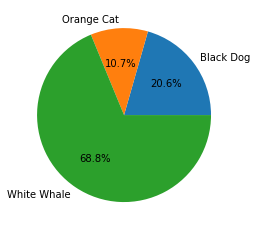

In [94]:
fraction = list(repeat_prop)
label = list(repeat_prop.index)
plt.pie(fraction, labels = label, autopct = '%1.1f%%');

From this aggregation of repeat customers, it would seem that White Whale is the most popular choice of Dog Food at nearly 70% of purchases from repeat customers, while Orange Cat and Black Dog occupying the remaining 30%. However, it is uncertain if this could be driven by a particular buyer or by a particular time. For instance, White Whale could be an enormous purchase done by a single individual or supplier which would greatly inflate it's popularity.

### Unique Repeat Customers

In [80]:
#number of repeats from dataset
repeat_df.groupby(['customer']).count()['brand'].describe()

count    3334.000000
mean        1.939412
std         0.756562
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         7.000000
Name: brand, dtype: float64

It would seem that on average the usual number of repeats is around 2, with the maximum of 7. Although it would seem that there are no outrageous outliers in terms of repeat buyers, it may still be useful to check if strictly unique buyers are considered. Unique buyers will be defined by having a unique combination of customer ID and petfood brand as It could be possible that a single user would purchase more than one kind of brand, and therefore qualifying that as a unique purchase.

In [98]:
unique_repeat_df = repeat_df[repeat_df.duplicated(subset = ['customer', 'brand'])]
unique_repeat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3132 entries, 9 to 10642
Data columns (total 5 columns):
customer        3132 non-null object
date_shipped    3132 non-null object
product_id      3132 non-null object
brand           3132 non-null object
channel         3132 non-null object
dtypes: object(5)
memory usage: 146.8+ KB


The number of unique entries is around half the original amount.

In [92]:
unique_repeat_counts = unique_repeat_df.groupby('brand').count()['customer']
unique_repeat_prop = unique_repeat_counts / unique_repeat.shape[0]
unique_repeat_prop

brand
Black Dog      0.201149
Orange Cat     0.110153
White Whale    0.688697
Name: customer, dtype: float64

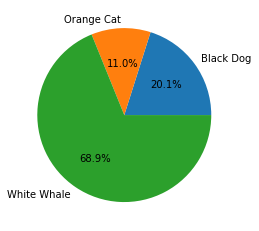

In [101]:
plt.pie(list(unique_repeat_prop), labels = list(unique_repeat_prop.index), autopct = '%1.1f%%');

However, even after considering unique purchases, it would seem that the metrics remain relatively unchanged, with Orange Cat, in this sample, increasing by one percent in proportion of purchases and White Whale decreasing by one percent.

### Repeat Customers Graphed Over Time
One possible explanation for the large proportion of White Whale purchases, may be that White Whale purchases were simply purchased in large quantities at a certain point. Perhaps there was a fad that increased sales, or that particular season neccessitated the purchase of a particular good only avaliable at particular brand (for instance, White Whale winter clothes).

In [119]:
dates = repeat_df.date_shipped
repeat_df.groupby(['date_shipped', 'brand'])['customer'].count()

date_shipped  brand      
2018-01-18    Black Dog        1
              White Whale      1
2018-01-19    Orange Cat       1
2018-01-23    Black Dog        1
2018-01-24    White Whale      1
2018-01-26    White Whale      1
2018-01-27    Black Dog        1
              Orange Cat       1
              White Whale      1
2018-01-31    Black Dog        1
2018-02-01    Black Dog        1
              White Whale      2
2018-02-02    Black Dog        2
              Orange Cat       1
              White Whale      9
2018-02-03    Black Dog        3
              Orange Cat       1
              White Whale      5
2018-02-07    Black Dog        4
              Orange Cat       1
              White Whale      4
2018-02-08    Black Dog        6
              Orange Cat       8
              White Whale     33
2018-02-09    Black Dog       10
              Orange Cat       1
              White Whale     35
2018-02-10    Black Dog        8
              Orange Cat      12
              Whi